$$\require{mhchem}$$
# Transport Problem: Advection + Diffusion, Dispersion


$\frac{\partial c}{\partial t}_x = -v\left(\frac{\partial c}{\partial x} \right)$

## Finite-Differences Solution

Advection step:

$\Delta t = v*\Delta x$

Thus:

${c_x}^{t2} = {c_{x-1}}^{t1}$

We need to correct for Numerical dispersion if retardation occurs.

${c_x}^{t2} + {q_x}^{t2} = {c_{x-1}}^{t1} + {q_x}^{t1} + (1-\omega)*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t1}-2 {c_{x}}^{t1}+{c_{x+1}}^{t1}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t1} +(1-2\alpha) {c_{x1}}^{t1} + \alpha {c_{x+1}}^{t1}\right)\right]+  
\omega*\left[ \frac{D_e \Delta t}{(\Delta x)^2} \left({c_{x-1}}^{t2}-2 {c_{x}}^{t2}+{c_{x+1}}^{t2}\right) -v \frac{\Delta t}{\Delta x}\left(\alpha {c_{x-1}}^{t2} +(1-2\alpha) {c_{x1}}^{t2} + \alpha {c_{x+1}}^{t2}\right)\right]$

## Model

#### libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import jit

In [2]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

### Defining problem as a coupled ODE system:

We define the coupled ODE system by assuming the discretization remains and writing the solution as a system of partial derivatives (ODE system) solved unsing a numerical solver.

In [3]:
@jit
def f(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = jnp.zeros(y.shape[0])
    
    
    r = r.at[0].set(-v*(y[0]-c_in)/(deltax/2) + (-mixf)*y[0] + mixf*y[1])
    
    #Update the middle_portion
    kernel = jnp.array([mixf, -2*mixf, mixf])
    r = r.at[1:-1].set(jnp.convolve(y,kernel, mode = 'valid'))
    #Update the last cell:
    r = r.at[-1].set(mixf*y[-1-1] + (-mixf)*y[-1])
    r = r.at[1:-1].add(-v*(jnp.roll(y,-1)[1:-1]-jnp.roll(y,1)[1:-1])/(2*deltax))
    r = r.at[-1].add(-v*(y[-1]-y[-2])/deltax)
    return r
    


In [4]:
@jit
def f(t,y,deltax,
      D,
      alpha_l,
      v,
      c_in):
    
    mixf = (D + v*alpha_l)/deltax**2
    
    r = jnp.zeros(y.shape[0])
    #upwind
    c_up = jnp.concatenate([c_in,y])
    
    #advection
    advec = jnp.gradient(c_up, deltax)*(-v)
    r = advec[1:]
    
    #dispersion
    diff = (D + v*alpha_l)*jnp.gradient(jnp.gradient(y,deltax),deltax)
    
    r = r.at[:].add(diff)

    return r
    


f(0,np.ones(y0.shape)*0.34,deltax,De,alpha_l,v,c_in)

In [5]:
@jit
def jac_fun(t,y,deltax,D,alpha_l,v,c_in):
    jac = jax.jacobian(f, argnums = 1)
    return jac(t,y,deltax,D,alpha_l,v,c_in)

In [6]:
ncells = 50

#### Running Problem:

Model the linear retardation of y-HCH in a 5 cm long and 5 cm diameter lab column with a sandy aquifer sample.

#### input

In [7]:
organic_carbon_aquifer = 0.05 #%
porosity = 0.3
alpha_l = 1e-3 #dispersivity [dm]
injected_volume = 450 #ml
flow_rate = 10*1e-5/3600 #l/hr
De = 1e-9
Kd = 6
c_in = 20 #microg/L

In [8]:
c0 = 0
q0 = 0
v = flow_rate/(np.pi*2.5**2*1e-2)/porosity
pore_volume = (np.pi*2.5**2)*5*1e-3
totx = 0.5 #dm
R = 1
max_time = 700*3600

In [9]:
v

4.7157020175376405e-07

### Coupled ODESolver approach

This process is not mature yet, however we can get an accurate result with a very large number of cells.

In [10]:
mixf = (alpha_l*v+De)
#Max x size (Peclet number = 0.1)
max_deltax = 1*mixf/v
x_steps_min = totx/max_deltax
x_steps_min = np.ceil(x_steps_min)
print(x_steps_min)

n_cells = int(x_steps_min)
deltax = totx/n_cells
y0 = np.repeat(0,n_cells)
y0

161.0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [11]:
mixf = (De + v*alpha_l)/deltax**2
r = np.zeros(y0.shape[0])

In [12]:
timesteps = np.arange(0,max_time,60)

In [13]:
import timeit

In [24]:
# record start time
t_0 = timeit.default_timer()
c_ode = scipy.integrate.odeint(f,y0,timesteps,args = (deltax,De,alpha_l,v,np.array([c_in])), 
                              #Dfun = jacob, 
                              tfirst = True,
                              hmax = 2*deltax**2/(3*(De+v*alpha_l)),
                              atol = 1e-10, rtol = 1e-10)
# record end time
t_1 = timeit.default_timer()
# calculate elapsed time and print
elapsed_time = (t_1 - t_0)
print(f"Elapsed time: {elapsed_time} s")

Elapsed time: 0.04751415200007614 s


In [33]:
# record start time
t_0 = timeit.default_timer()
c_ode_j = scipy.integrate.odeint(f,y0,timesteps,args = (deltax,De,alpha_l,v,np.array([c_in])), 
                              Dfun = jac_fun, 
                              tfirst = True,
                              atol = 1e-11, rtol = 1e-11)
# record end time
t_1 = timeit.default_timer()
# calculate elapsed time and print
elapsed_time = (t_1 - t_0)
print(f"Elapsed time: {elapsed_time} s")

Elapsed time: 0.46526859600089665 s


In [16]:
cumulated_volume = flow_rate*timesteps

### Analytical solution:

In [17]:
def analytical(t,c_in,L,v,Dl,R):
    c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
                  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))
    return c

In [18]:
c_out_ana = np.zeros(timesteps.shape)
Dl = De+v*alpha_l
for i in range(timesteps.shape[0]):
    c_out_ana[i] = analytical(timesteps[i],c_in,totx,v,Dl,R) 
    

/tmp/ipykernel_3413/707810831.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  c = (c_in/2)*(scipy.special.erfc((L-v*t/R)/(np.sqrt(4*Dl*t/R)))+np.exp(v*L/Dl)*
/tmp/ipykernel_3413/707810831.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  scipy.special.erfc((L+v*t/R)/np.sqrt(4*Dl*t/R)))


In [19]:
analytical(timesteps[3],c_in,totx,v,Dl,R) 

0.0

In [20]:
pore_flushes = cumulated_volume/pore_volume
#pore_flushes[::7]

#### Plotting and comparing solutions:

Text(0, 0.5, '[y-HCH] [$\\mu g/L$]')

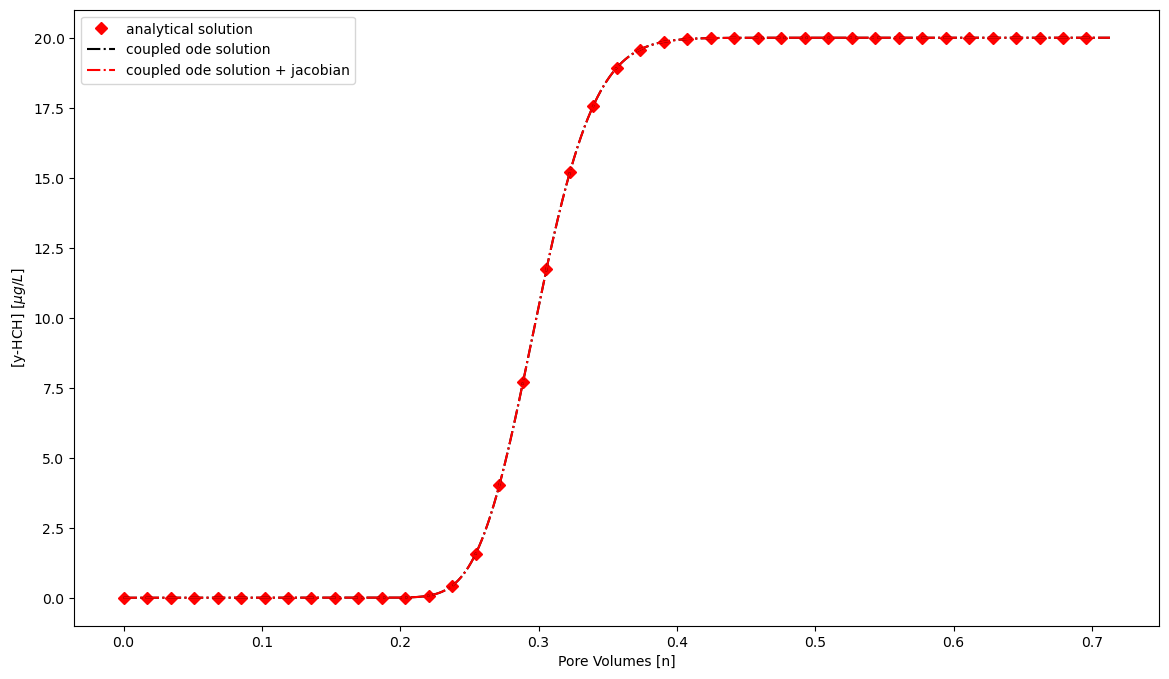

In [23]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)
ax.plot(pore_flushes[::1000],c_out_ana[::1000], 'Dr', label = 'analytical solution')
ax.plot(pore_flushes,c_ode[:,-1], '-.k', label = 'coupled ode solution')
ax.plot(pore_flushes,c_ode_j[:,-1], '-.r', label = 'coupled ode solution + jacobian')

#ax.set_xlim([0,6])
ax.legend()
ax.set_xlabel('Pore Volumes [n]')
ax.set_ylabel(r'[y-HCH] [$\mu g/L$]')